In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.read_csv('Davis Elec Hourly 1_24.2_25.csv')

,Timestamp,Davis Hall Total Electric Meter Demand (C),Davis Hall Total Electric Meter Usage (C)
0,2024-01-01T00:00:00-08:00 Los_Angeles,80.63999938964844kW,76.25kWh
1,2024-01-01T01:00:00-08:00 Los_Angeles,79.04000091552734kW,77.25kWh
2,2024-01-01T02:00:00-08:00 Los_Angeles,81.72799682617188kW,75.25kWh
3,2024-01-01T03:00:00-08:00 Los_Angeles,81.02400207519531kW,77.25kWh
4,2024-01-01T04:00:00-08:00 Los_Angeles,81.91999816894531kW,76.5kWh
...,...,...,...
10171,2025-02-27T19:00:00-08:00 Los_Angeles,201.4080047607422kW,193.5kWh
10172,2025-02-27T20:00:00-08:00 Los_Angeles,174.39999389648438kW,135.5kWh
10173,2025-02-27T21:00:00-08:00 Los_Angeles,122.55999755859375kW,115.25kWh
10174,2025-02-27T22:00:00-08:00 Los_Angeles,112.25599670410156kW,108.5kWh


In [3]:
da = pd.read_csv('Davis Elec Hourly 1_24.2_25.csv')
da['Timestamp'] = pd.to_datetime(da['Timestamp'].str.extract(r'(.*?)(?= Los_Angeles)')[0])
da['Demand_kW'] = da.iloc[:,1].str.replace('kW', '').astype(float)
da['Usage_kWh'] = da.iloc[:,2].str.replace('kWh', '').astype(float)

sd = pd.read_csv('SaturdjaDai elec_hr 1_24-2_25.csv')
sd['Timestamp'] = pd.to_datetime(sd['Timestamp'].str.extract(r'(.*?)(?= Los_Angeles)')[0])
sd['Demand_kW'] = sd.iloc[:,1].str.replace('kW', '').astype(float)
sd['Usage_kWh'] = sd.iloc[:,2].str.replace('kWh', '').astype(float)

C:\Users\joelt\AppData\Local\Temp\ipykernel_13448\2741872308.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  da['Timestamp'] = pd.to_datetime(da['Timestamp'].str.extract(r'(.*?)(?= Los_Angeles)')[0])
C:\Users\joelt\AppData\Local\Temp\ipykernel_13448\2741872308.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sd['Timestamp'] = pd.to_datetime(sd['Timestamp'].str.extract(r'(.*?)(?= Los_Angeles)')[0])


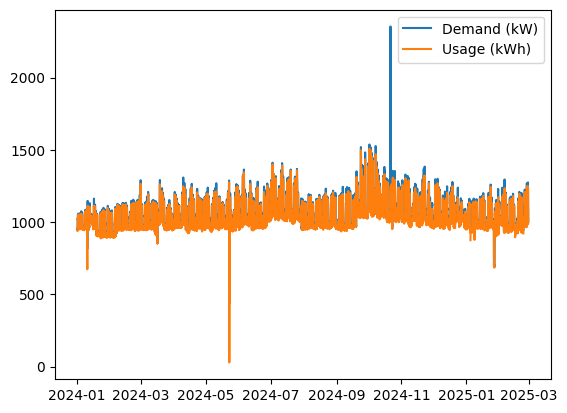

In [4]:
elec = pd.merge(da[['Timestamp', 'Demand_kW', 'Usage_kWh']],
                sd[['Timestamp', 'Demand_kW', 'Usage_kWh']],
                on='Timestamp', suffixes=('_da', '_sd'))

elec['Demand_kW'] = elec['Demand_kW_da'] + elec['Demand_kW_sd']
elec['Usage_kWh'] = elec['Usage_kWh_da'] + elec['Usage_kWh_sd']

# elec = elec[['Timestamp', 'Demand_kW', 'Usage_kWh']]

summer_months = [6, 7, 8, 9]

elec['Timestamp'] = pd.to_datetime(elec['Timestamp'], utc=True).dt.tz_convert(None)

elec['month'] = elec['Timestamp'].dt.month
elec['hour'] = elec['Timestamp'].dt.hour
elec['season'] = np.where(elec['month'].isin(summer_months), 'summer', 'winter')

plt.plot(elec['Timestamp'], elec['Demand_kW'], label='Demand (kW)')
plt.plot(elec['Timestamp'], elec['Usage_kWh'], label='Usage (kWh)')
plt.legend()

In [5]:
# #new code

# # Set initial parameters (defaults before the loop)
# P_values = [0.95, 0.98]         # Battery round-trip efficiencies
# E_values = [100, 500, 1000, 4000]     # Battery energy capacities
# Bd = 0.001                      # Daily battery degradation rate (0.1%)
# Ci = 10000                      # One-time battery installation cost

# #rates defined on B-20 PG&E rates
# #https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_B-20.pdf

# # Define time periods and rates for secondary voltage customers
# summer_peak = range(16, 21)     # 4–9 PM
# summer_part_peak = list(range(14, 16)) + list(range(21, 23))  # 2–4 PM & 9–11 PM
# winter_peak = range(16, 21)
# super_off_peak_months = [3, 4, 5]  # Mar–May super off-peak from 9 AM–2 PM
# super_off_peak_hours = range(9, 14)

In [6]:
def repeat_dataset_for_years(df, years=15):
    df = df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_convert(None)

    repeated_dfs = []
    original_start = df['Timestamp'].min()

    for i in range(years):
        df_copy = df.copy()
        time_offset = pd.DateOffset(years=i)
        df_copy['Timestamp'] = df_copy['Timestamp'] + time_offset
        repeated_dfs.append(df_copy)

    return pd.concat(repeated_dfs, ignore_index=True)


In [7]:
import cvxpy as cp

def find_break_even_capacity(df, P=0.99, Bd=0.001, Ci_per_kWh=200, max_E=10000):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_convert(None)
    df['month'] = df['Timestamp'].dt.month
    df['hour'] = df['Timestamp'].dt.hour

    # Precompute rate
    summer_months = [6, 7, 8, 9]
    super_off_peak_months = [3, 4, 5]
    super_off_peak_hours = range(9, 14)
    summer_peak = range(16, 21)
    summer_part_peak = list(range(14, 16)) + list(range(21, 23))
    winter_peak = range(16, 21)

    def get_rate(row):
        hour = row['hour']
        month = row['month']
        if month in summer_months:
            if hour in summer_peak: return 0.20832
            elif hour in summer_part_peak: return 0.16020
            else: return 0.12220
        else:
            if month in super_off_peak_months and hour in super_off_peak_hours: return 0.04451
            elif hour in winter_peak: return 0.17965
            else: return 0.12189

    df['rate'] = df.apply(get_rate, axis=1)
    df['GridOnlyCost'] = df['Usage_kWh'] * df['rate']
    grid_only_cost = df['GridOnlyCost'].sum()

    U = df['Usage_kWh'].values
    R = df['rate'].values
    T = len(U)
    df['date'] = df['Timestamp'].dt.date
    degradation_mask = (df['date'] != df['date'].shift(1)).astype(float).values

    def get_battery_cost(e):
        B = cp.Variable(T)
        D = cp.Variable(T)
        C = cp.Variable(T)

        constraints = [B[0] == 0]
        for t in range(T):
            constraints += [
                B[t] >= 0,
                B[t] <= e,
                D[t] >= 0,
                D[t] <= P * B[t],
                C[t] >= 0,
                C[t] <= e
            ]
            if t > 0:
                constraints.append(B[t] == B[t-1] - D[t-1] / P + C[t-1])

        G = U - D + C / P
        constraints += [G >= 0]
        degradation_cost = Bd * cp.sum(cp.multiply(cp.multiply(degradation_mask, B), R))
        # install_cost = Ci_per_kWh * np.log(e)
        # install_cost = Ci_per_kWh * np.sqrt(e)  # Adjusted to be more realistic
        install_cost = Ci_per_kWh * e**0.75
        battery_cost = cp.sum(cp.multiply(G, R)) + degradation_cost + install_cost

        problem = cp.Problem(cp.Minimize(battery_cost), constraints)
        problem.solve()
        return battery_cost.value if problem.status == 'optimal' else None

    # Binary search for break-even E
    low = 1
    high = max_E
    best = None

    loop_counter = 0  # To track number of iterations

    while low <= high:
        mid = (low + high) // 2
        loop_counter += 1
        print(f"[Step {loop_counter}] 🔍 Testing E = {mid} kWh")

        cost = get_battery_cost(mid)

        if cost is None:
            print(f"⚠️ Solver failed at E = {mid}")
            low = mid + 1
        elif cost < grid_only_cost:
            print(f"✅ E = {mid} is cheaper (${cost:.2f} < ${grid_only_cost:.2f})")
            best = (mid, cost)
            high = mid - 1
        else:
            print(f"❌ E = {mid} is not cost-effective (${cost:.2f} ≥ ${grid_only_cost:.2f})")
            low = mid + 1


    if best:
        e, battery_cost = best
        print(f"✅ Break-even battery size: {e} kWh")
        print(f"🔋 Battery cost: ${battery_cost:.2f}")
        print(f"💰 Grid-only cost: ${grid_only_cost:.2f}")
        print(f"📉 Savings: ${grid_only_cost - battery_cost:.2f}")
        return e, battery_cost, grid_only_cost
    else:
        print("❌ No break-even point found within given E range.")
        return None, None, grid_only_cost


In [8]:
def find_break_even_capacity_param(df, P=0.99, Bd=0.000027, Ci_per_kWh=300, start_E=1100, max_E=10000, step_size=100):
    df = df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_convert(None)
    df['month'] = df['Timestamp'].dt.month
    df['hour'] = df['Timestamp'].dt.hour

    # Precompute rate
    summer_months = [6, 7, 8, 9]
    super_off_peak_months = [3, 4, 5]
    super_off_peak_hours = range(9, 14)
    summer_peak = range(16, 21)
    summer_part_peak = list(range(14, 16)) + list(range(21, 23))
    winter_peak = range(16, 21)

    def get_rate(row):
        hour = row['hour']
        month = row['month']
        if month in summer_months:
            if hour in summer_peak: return 0.20832
            elif hour in summer_part_peak: return 0.16020
            else: return 0.12220
        else:
            if month in super_off_peak_months and hour in super_off_peak_hours: return 0.04451
            elif hour in winter_peak: return 0.17965
            else: return 0.12189

    df['rate'] = df.apply(get_rate, axis=1)
    df['GridOnlyCost'] = df['Usage_kWh'] * df['rate']
    grid_only_cost = df['GridOnlyCost'].sum()

    U = df['Usage_kWh'].values
    R = df['rate'].values
    T = len(U)
    df['date'] = df['Timestamp'].dt.date
    degradation_mask = (df['date'] != df['date'].shift(1)).astype(float).values

    # --- Define Variables and Parameter ---
    E_param = cp.Parameter(nonneg=True)
    B = cp.Variable(T)
    D = cp.Variable(T)
    C = cp.Variable(T)

    constraints = [B[0] == 0]
    for t in range(T):
        constraints += [
            B[t] >= 0,
            B[t] <= E_param,
            D[t] >= 0,
            D[t] <= P * B[t],
            C[t] >= 0,
            C[t] <= E_param
        ]
        if t > 0:
            constraints.append(B[t] == B[t-1] - D[t-1] / P + C[t-1])

    G = U - D + C / P
    constraints += [G >= 0]

    degradation_cost = Bd * cp.sum(cp.multiply(cp.multiply(degradation_mask, B), R))
    install_cost = Ci_per_kWh * cp.power(E_param, 0.75)
    battery_cost_expr = cp.sum(cp.multiply(G, R)) + degradation_cost + install_cost

    problem = cp.Problem(cp.Minimize(battery_cost_expr), constraints)

    # --- Grid Search over E Values ---
    results = []
    for e in range(start_E, max_E + 1, step_size):
        E_param.value = e
        problem.solve()
        if problem.status == 'optimal':
            results.append((e, battery_cost_expr.value))
            print(f"✅ E = {e} kWh, Total Cost = ${battery_cost_expr.value:.2f}")
        else:
            print(f"⚠️ Solver failed at E = {e} kWh")

    if results:
        best_E, best_cost = min(results, key=lambda x: x[1])
        print(f"\n🎯 Best Battery Size: {best_E} kWh")
        print(f"🔋 Battery Total Cost: ${best_cost:.2f}")
        print(f"💰 Grid-Only Cost: ${grid_only_cost:.2f}")
        print(f"📉 Net Savings: ${grid_only_cost - best_cost:.2f}")
        return best_E, best_cost, grid_only_cost, results
    else:
        print("❌ No feasible solution found within the tested range.")
        return None, None, grid_only_cost, results


In [9]:
def find_break_even_capacity_param(
    df, P=0.99, Bd=0.000027, Ci_per_kWh=300,
    start_E=0, max_E=10000, step_size=100,
    csv_path='battery_cost_results.csv'
):
    df = df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_convert(None)
    df['month'] = df['Timestamp'].dt.month
    df['hour'] = df['Timestamp'].dt.hour

    # Precompute rate
    summer_months = [6, 7, 8, 9]
    super_off_peak_months = [3, 4, 5]
    super_off_peak_hours = range(9, 14)
    summer_peak = range(16, 21)
    summer_part_peak = list(range(14, 16)) + list(range(21, 23))
    winter_peak = range(16, 21)

    def get_rate(row):
        hour = row['hour']
        month = row['month']
        if month in summer_months:
            if hour in summer_peak: return 0.20832
            elif hour in summer_part_peak: return 0.16020
            else: return 0.12220
        else:
            if month in super_off_peak_months and hour in super_off_peak_hours: return 0.04451
            elif hour in winter_peak: return 0.17965
            else: return 0.12189

    df['rate'] = df.apply(get_rate, axis=1)
    df['GridOnlyCost'] = df['Usage_kWh'] * df['rate']
    grid_only_cost = df['GridOnlyCost'].sum()

    U = df['Usage_kWh'].values
    R = df['rate'].values
    T = len(U)
    df['date'] = df['Timestamp'].dt.date
    degradation_mask = (df['date'] != df['date'].shift(1)).astype(float).values

    # --- Define Variables and Parameter ---
    E_param = cp.Parameter(nonneg=True)
    B = cp.Variable(T)
    D = cp.Variable(T)
    C = cp.Variable(T)

    constraints = [B[0] == 0]
    for t in range(T):
        constraints += [
            B[t] >= 0,
            B[t] <= E_param,
            D[t] >= 0,
            D[t] <= P * B[t],
            C[t] >= 0,
            C[t] <= E_param
        ]
        if t > 0:
            constraints.append(B[t] == B[t-1] - D[t-1] / P + C[t-1])

    G = U - D + C / P
    constraints += [G >= 0]

    degradation_cost = Bd * cp.sum(cp.multiply(cp.multiply(degradation_mask, B), R))
    install_cost = Ci_per_kWh * cp.power(E_param, 0.75)
    battery_cost_expr = cp.sum(cp.multiply(G, R)) + degradation_cost + install_cost

    results = []
    for e in range(start_E, max_E + 1, step_size):
        E_param.value = e
        problem = cp.Problem(cp.Minimize(battery_cost_expr), constraints)
        problem.solve()
        if problem.status == 'optimal':
            results.append((e, battery_cost_expr.value))
            print(f"✅ E = {e} kWh, Total Cost = ${battery_cost_expr.value:.2f}")
        else:
            results.append((e, np.inf))
            print(f"⚠️ Solver failed at E = {e} kWh")

    # Convert to DataFrame and write to CSV
    results_df = pd.DataFrame(results, columns=["Battery_kWh", "Total_Cost"])
    results_df.to_csv(csv_path, index=False)
    print(f"\n📝 Results saved to: {csv_path}")

    # Find best result
    feasible_results = [(e, c) for e, c in results if np.isfinite(c)]
    if feasible_results:
        best_E, best_cost = min(feasible_results, key=lambda x: x[1])
        print(f"\n🎯 Best Battery Size: {best_E} kWh")
        print(f"🔋 Battery Total Cost: ${best_cost:.2f}")
        print(f"💰 Grid-Only Cost: ${grid_only_cost:.2f}")
        print(f"📉 Net Savings: ${grid_only_cost - best_cost:.2f}")
        return best_E, best_cost, grid_only_cost, results_df
    else:
        print("❌ No feasible solution found within the tested range.")
        return None, None, grid_only_cost, results_df


In [ ]:
find_break_even_capacity_param(repeat_dataset_for_years(sd, years=3))

c:\Users\joelt\S25\295venv\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


✅ E = 0 kWh, Total Cost = $3715401.77
✅ E = 100 kWh, Total Cost = $3714741.94
✅ E = 200 kWh, Total Cost = $3711063.32
